In [1]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import numpy

In [2]:
data= 'titanic_train.csv'
test_data="titanic_test.csv"

In [3]:
X= pd.read_csv(data, index_col='PassengerId')
X_test=pd.read_csv(test_data, index_col="PassengerId")
y= X.Survived
X=X.drop(['Survived'], axis=1)
print(X.head())

             Pclass                                               Name  \
PassengerId                                                              
1                 3                            Braund, Mr. Owen Harris   
2                 1  Cumings, Mrs. John Bradley (Florence Briggs Th...   
3                 3                             Heikkinen, Miss. Laina   
4                 1       Futrelle, Mrs. Jacques Heath (Lily May Peel)   
5                 3                           Allen, Mr. William Henry   

                Sex   Age  SibSp  Parch            Ticket     Fare Cabin  \
PassengerId                                                                
1              male  22.0      1      0         A/5 21171   7.2500   NaN   
2            female  38.0      1      0          PC 17599  71.2833   C85   
3            female  26.0      0      0  STON/O2. 3101282   7.9250   NaN   
4            female  35.0      1      0            113803  53.1000  C123   
5              male  35.0

In [4]:
X_train, X_val, Y_train, Y_val = train_test_split(X,y, test_size=0.3, random_state= 1)

In [5]:
# Get names of columns with missing values
cols_with_missing = [col for col in X_train.columns if X_train[col].isnull().any()]
print("cols with missing: ",cols_with_missing)
object_cols = [col for col in X_train.columns if X_train[col].dtype == "object"]
print("object cols: ",object_cols)
object_nunique = list(map(lambda col: X_train[col].nunique(), object_cols))
d = dict(zip(object_cols, object_nunique))
print("no. of unique entries: ", d)
low_cardinality_cols = [col for col in object_cols if X_train[col].nunique() < 10]
high_cardinality_cols = list(set(object_cols)-set(low_cardinality_cols))
print("low_cardinality_cols: ",low_cardinality_cols)
print("high_cardinality_cols: ", high_cardinality_cols)
numerical_cols= list(set(X_train.columns)-set(object_cols))
print("numerical_cols", numerical_cols)

cols with missing:  ['Age', 'Cabin', 'Embarked']
object cols:  ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']
no. of unique entries:  {'Name': 623, 'Sex': 2, 'Ticket': 512, 'Cabin': 106, 'Embarked': 3}
low_cardinality_cols:  ['Sex', 'Embarked']
high_cardinality_cols:  ['Cabin', 'Name', 'Ticket']
numerical_cols ['Parch', 'SibSp', 'Fare', 'Age', 'Pclass']


In [6]:
X_train= X_train.drop(high_cardinality_cols, axis=1)
X_val= X_val.drop(high_cardinality_cols, axis=1)
X_test= X_test.drop(high_cardinality_cols, axis=1)

In [7]:
numerical_transformer = SimpleImputer(strategy='median')
categorical_transformer = Pipeline(steps=[ ('imputer', SimpleImputer(strategy='most_frequent')),
                                           ('onehot', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(transformers=[('num', numerical_transformer, numerical_cols),
                                                 ('cat', categorical_transformer, low_cardinality_cols)])

In [8]:
models=[]
results=[]
names=[]
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
for name, model in models:
    my_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('standardize', StandardScaler()) ,('model', model)])
    my_pipeline.fit(X_train, Y_train)
    score = cross_val_score(my_pipeline, X_val, Y_val, cv=4, scoring='accuracy')
    names.append(name)
    results.append(score.mean())
    print(name," : ",score.mean())

LR  :  0.7537313432835822
LDA  :  0.753731343283582
KNN  :  0.7873134328358209
CART  :  0.6753731343283582
NB  :  0.7686567164179103
SVM  :  0.7835820895522388


<AxesSubplot:>

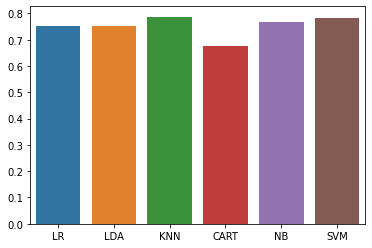

In [9]:
sns.barplot(x=names, y=results)

In [10]:
print(X_train.head())

             Pclass     Sex   Age  SibSp  Parch     Fare Embarked
PassengerId                                                      
115               3  female  17.0      0      0  14.4583        C
875               2  female  28.0      1      0  24.0000        C
77                3    male   NaN      0      0   7.8958        S
877               3    male  20.0      0      0   9.8458        S
675               2    male   NaN      0      0   0.0000        S


In [11]:
# tuning knn
k_values = numpy.array([1,3,5,7,9,11,13,15,17,19,21])
param_grid = dict(n_neighbors=k_values)
tune_X_train= preprocessor.fit_transform(X_train)
tune_X_val= preprocessor.transform(X_val)
tune_X_train= StandardScaler().fit_transform(tune_X_train)
tune_X_val= StandardScaler().fit_transform(tune_X_val)
model = KNeighborsClassifier()
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=4)
grid_result = grid.fit(tune_X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


Best: 0.841077 using {'n_neighbors': 15}
0.768879 (0.025872) with: {'n_neighbors': 1}
0.816998 (0.013450) with: {'n_neighbors': 3}
0.828246 (0.013919) with: {'n_neighbors': 5}
0.829828 (0.010116) with: {'n_neighbors': 7}
0.833044 (0.013878) with: {'n_neighbors': 9}
0.834646 (0.011814) with: {'n_neighbors': 11}
0.839464 (0.008308) with: {'n_neighbors': 13}
0.841077 (0.015435) with: {'n_neighbors': 15}
0.836280 (0.021467) with: {'n_neighbors': 17}
0.825041 (0.010477) with: {'n_neighbors': 19}
0.823439 (0.013156) with: {'n_neighbors': 21}


In [12]:
model=KNeighborsClassifier(n_neighbors=15)
score=cross_val_score(model, tune_X_val, Y_val, cv=4, scoring='accuracy')
print(score.mean())

0.75


In [13]:
c_values = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 1.3, 1.5, 1.7, 2.0]
kernel_values = ['linear', 'poly', 'rbf', 'sigmoid']
param_grid = dict(C=c_values, kernel=kernel_values)
model = SVC()
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=4)
grid_result = grid.fit(tune_X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.850693 using {'C': 2.0, 'kernel': 'rbf'}
0.799349 (0.020040) with: {'C': 0.1, 'kernel': 'linear'}
0.776840 (0.027745) with: {'C': 0.1, 'kernel': 'poly'}
0.813792 (0.029448) with: {'C': 0.1, 'kernel': 'rbf'}
0.802554 (0.019574) with: {'C': 0.1, 'kernel': 'sigmoid'}
0.799349 (0.020040) with: {'C': 0.3, 'kernel': 'linear'}
0.820203 (0.010534) with: {'C': 0.3, 'kernel': 'poly'}
0.825000 (0.038231) with: {'C': 0.3, 'kernel': 'rbf'}
0.760866 (0.016141) with: {'C': 0.3, 'kernel': 'sigmoid'}
0.799349 (0.020040) with: {'C': 0.5, 'kernel': 'linear'}
0.834636 (0.024825) with: {'C': 0.5, 'kernel': 'poly'}
0.828205 (0.041849) with: {'C': 0.5, 'kernel': 'rbf'}
0.739992 (0.020727) with: {'C': 0.5, 'kernel': 'sigmoid'}
0.799349 (0.020040) with: {'C': 0.7, 'kernel': 'linear'}
0.828205 (0.028394) with: {'C': 0.7, 'kernel': 'poly'}
0.828174 (0.041291) with: {'C': 0.7, 'kernel': 'rbf'}
0.704725 (0.026916) with: {'C': 0.7, 'kernel': 'sigmoid'}
0.799349 (0.020040) with: {'C': 0.9, 'kernel': 'linear'

In [14]:
model=SVC(C=1.0, kernel='rbf')
score=cross_val_score(model, tune_X_val, Y_val, cv=4, scoring='accuracy')
print(score.mean())

0.7798507462686568


In [15]:
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('standardize', StandardScaler()) ,('model', model)])

In [16]:
my_pipeline.fit(X_train, Y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['Parch', 'SibSp', 'Fare',
                                                   'Age', 'Pclass']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Sex', 'Embarked'])])),
                ('standardize', StandardScaler()), ('model', SVC())])

In [17]:
score=cross_val_score(model, tune_X_val, Y_val, cv=4, scoring='accuracy')
print(score.mean())

0.7798507462686568


In [18]:
Y_test=my_pipeline.predict(X_test)

In [19]:
Y_test.dtype


dtype('int64')

In [20]:
# Save test predictions to file
output = pd.DataFrame({'PassengerId': X_test.index,
                       'Survived': Y_test})
output.to_csv('submission.csv', index=False)